# Cooper Seligson
## SI 630: Final Project

# Humor Detection

## Load Modules

In [1]:
from collections import Counter
import re
import time

import gensim
import gensim.downloader as api
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import pandas as pd
from scipy.sparse import hstack
from scipy.stats import describe
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression, BayesianRidge
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
)
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR, NuSVR, SVR

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
# Set theme of seaborn 
sns.set()

## Load Data

In [4]:
train_df = pd.read_csv("data/task-1/train.csv", dtype=str)
dev_df = pd.read_csv("data/task-1/dev.csv", dtype=str)
test_df = pd.read_csv("data/task-1/test.csv", dtype=str)

For Development

In [5]:
test_df = dev_df.copy()

## Scoring Function

Calculate Root Mean Squared Error

In [6]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

## Baseline

In [7]:
y_train = train_df["meanGrade"].astype(float)
y_test = test_df["meanGrade"].astype(float)

Turn meanGrade into into an integer for other functions needed later.

In [8]:
y_train_int = y_train.astype(float) * 10
y_train_int = y_train_int.astype(int)

In [9]:
meanGrade = np.mean(y_train)
baseline_rmse = rmse(y_test,[meanGrade] * len(y_test))

In [10]:
baseline_rmse

0.5783998503042385

## Feature Engineering 

Remove < and /> from original headline and create a new headline using the edited word

In [11]:
train_df["new"] = train_df.apply(
    lambda x: re.sub(r"<.+/>", x["edit"], x["original"]), axis=1
)
train_df["original"] = train_df["original"].str.replace(r"<(.+)/>", "\g<1>")

test_df["new"] = test_df.apply(
    lambda x: re.sub(r"<.+/>", x["edit"], x["original"]), axis=1
)
test_df["original"] = test_df["original"].str.replace(r"<(.+)/>", "\g<1>")

Load Stopwords

In [12]:
stop_words = set(stopwords.words("english"))

### Word2Vec

[Using word2vec to Analyze News Headlines and Predict Article Success](https://towardsdatascience.com/using-word2vec-to-analyze-news-headlines-and-predict-article-success-cdeda5f14751)

Utilize the [word2vec-google-news-300](https://code.google.com/archive/p/word2vec/) model. This model was created from a Google News dataset which should be a good dataset to use to represent the vectors since the dataset is funniness of news headlines.

In [15]:
model = api.load("word2vec-google-news-300")

In [16]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.vocab]
    return np.mean(model[doc], axis=0)

def preprocess(text):
    # Lowercase and Tokenize
    doc = word_tokenize(text.lower())
    # Remove Stop Words
    doc = [word for word in doc if word not in stop_words]
    # Remove non-alphabet tokens
    doc = [word for word in doc if word.isalpha()]
    return doc

def to_vector(df, column):
    headlines = df[column].tolist()
    corpus = [preprocess(title) for title in headlines]
    X = []
    # append the vector for each document
    for doc in corpus:  
        vector = document_vector(model, doc)
        X.append(vector)
    return np.array(X)

In [17]:
# to_vector(train_df.sample(10), "original")

In [18]:
X_train_orig = to_vector(train_df, "original")
X_train_new = to_vector(train_df, "new")
X_test_orig = to_vector(test_df, "original")
X_test_new = to_vector(test_df, "new")

Check to make sure that the sizes match

In [19]:
assert len(X_train_orig) == len(X_train_new) == len(train_df) 

In [20]:
assert len(X_test_orig) == len(X_test_new) == len(test_df) 

Combine the vectors from the original and edited headline 

In [21]:
X_train = [
    np.concatenate((X_train_orig[c], X_train_new[c]), axis=None)
    for c in range(len(X_train_orig))
]
X_test = [
    np.concatenate((X_test_orig[c], X_test_new[c]), axis=None)
    for c in range(len(X_test_orig))
]

## Utility Functions

Function to round the prredictions to nearest even decimal since that is the form of the train set

In [22]:
def roundPred(predictions):
    final_predictions = []
    for val in predictions:
        val = int(val * 10)
#         if val % 2 == 1:
#             val += 1
        final_predictions.append(val / 10)
    return final_predictions

## Models

In [23]:
model_results = {}

Add Baseline

In [24]:
model_results["BASELINE"] = baseline_rmse

### Random Forest Regressor

In [25]:
rf_reg = RandomForestRegressor(n_estimators=10, n_jobs=-1, verbose=1, random_state=42)
rf_reg.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.4s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=1, warm_start=False)

In [26]:
predictions = roundPred(rf_reg.predict(X_test))

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


In [27]:
rf_rmse = rmse(test_df["meanGrade"], predictions)

In [28]:
rf_rmse

0.5909997415412804

In [29]:
model_results["Random Forest"] = rf_rmse

Random Forest is producing very strong results, let's try changing the n_estimators to improve the model

In [30]:
results_rf_optimize = {}

In [32]:
time_dict = {}

In [33]:
for n in range(10, 101, 10):
    start = time.time()
    rf_reg = RandomForestRegressor(n_estimators=n, random_state=42, n_jobs=-1)
    rf_reg.fit(X_train, y_train)
    predictions = roundPred(rf_reg.predict(X_test))
    rf_rmse = rmse(test_df["meanGrade"], predictions)
    results_rf_optimize[n] = rf_rmse
    end = time.time()
    time_dict[n]= start-end
    print(f"N: {n} --> {rf_rmse:.5f}")

N: 10 --> 0.59090
N: 20 --> 0.57663
N: 30 --> 0.57497
N: 40 --> 0.57117
N: 50 --> 0.56758
N: 60 --> 0.56721
N: 70 --> 0.56688
N: 80 --> 0.56689
N: 90 --> 0.56662
N: 100 --> 0.56646


Graph the results from the Random Forest Regressor

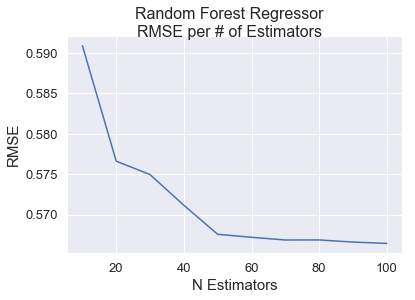

In [34]:
results_df = (
    pd.DataFrame(results_rf_optimize.items(), columns=["n_estimators", "RMSE"])
    .sort_values("n_estimators")
    .reset_index(drop=True)
)
ax = sns.lineplot(x="n_estimators", y="RMSE", data=results_df, color="b")
plt.suptitle("Random Forest Regressor\nRMSE per # of Estimators", fontsize=16)
ax.set_xlabel("N Estimators", fontsize=15)
ax.set_ylabel("RMSE", fontsize=15)
ax.xaxis.set_tick_params(labelsize=13)
ax.yaxis.set_tick_params(labelsize=13)

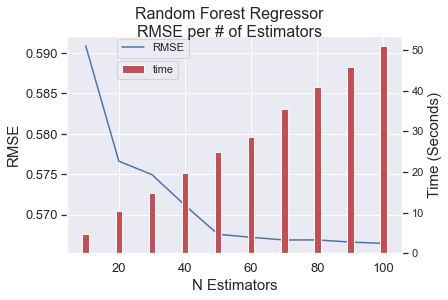

In [35]:
time_df = (
    pd.DataFrame(time_dict.items(), columns=["n_estimators", "time"])
    .sort_values("time")
    .reset_index(drop=True)
)
time_df["time"] = time_df["time"].apply(lambda x: abs(x))

fig = plt.figure()
ax1 = fig.add_subplot(111)
ln1 = ax1.plot(results_df["n_estimators"], results_df["RMSE"], color='b', label="RMSE")
ax2 = ax1.twinx()
ln2 = ax2.bar(time_df["n_estimators"], time_df["time"], color='r', width = 2, label="time")
ax2.grid(False)
plt.suptitle("Random Forest Regressor\nRMSE per # of Estimators", fontsize=16)
ax1.set_xlabel("N Estimators", fontsize=15)
ax1.set_ylabel("RMSE", fontsize=15)
ax2.set_ylabel("Time (Seconds)", fontsize=15)
ax1.xaxis.set_tick_params(labelsize=13)
ax1.yaxis.set_tick_params(labelsize=13)
ax1.legend(loc = (.15,.9), frameon = True)
ax2.legend( loc = (.15, .8), frameon = True)

In [36]:
results_df.sort_values("RMSE").head(1)

,n_estimators,RMSE
9,100,0.566456


In [37]:
model_results["Random Forest"] = results_df.sort_values("RMSE").head(1).iloc[0]["RMSE"]

### Ada Boost Regressor

In [38]:
ada_results_optimize = {}

In [39]:
for n in range(10, 51, 10):
    ada_reg = AdaBoostRegressor(
        base_estimator=DecisionTreeRegressor(max_depth=3, random_state=42),
        n_estimators=n,
        random_state=42,
        loss="linear",
    )
    ada_reg.fit(X_train, y_train)
    predictions = roundPred(ada_reg.predict(X_test))
    ada_rmse = rmse(test_df["meanGrade"], predictions)
    ada_results_optimize[n] = ada_rmse
    print(f"N: {n} --> {ada_rmse:.5f}")

N: 10 --> 0.57104
N: 20 --> 0.57164
N: 30 --> 0.57164
N: 40 --> 0.57164
N: 50 --> 0.57164


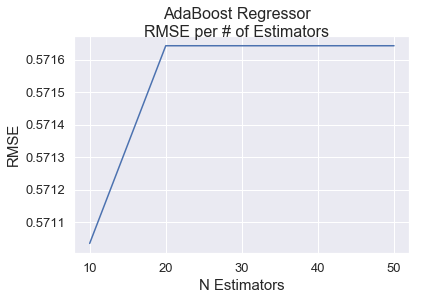

In [40]:
ada_results_df = (
    pd.DataFrame(ada_results_optimize.items(), columns=["n_estimators", "RMSE"])
    .sort_values("n_estimators")
    .reset_index(drop=True)
)
ax = sns.lineplot(x="n_estimators", y="RMSE", data=ada_results_df)
plt.suptitle("AdaBoost Regressor\nRMSE per # of Estimators", fontsize=16)
ax.set_xlabel("N Estimators", fontsize=15)
ax.set_ylabel("RMSE", fontsize=15)
ax.xaxis.set_tick_params(labelsize=13)
ax.yaxis.set_tick_params(labelsize=13)

In [41]:
ada_results_df.sort_values("RMSE").head(1)

,n_estimators,RMSE
0,10,0.571035


In [42]:
model_results["Ada Boost"] = ada_results_df.sort_values("RMSE").head(1).iloc[0]["RMSE"]

### BayesianRidge

In [44]:
bay_reg = BayesianRidge(tol=1e-20, verbose=2, normalize=True)
bay_reg.fit(X_train, y_train)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=True, tol=1e-20, verbose=2)

In [45]:
predictions = roundPred(bay_reg.predict(X_test))

In [46]:
bay_ridge_rmse = rmse(test_df["meanGrade"], predictions)

In [47]:
bay_ridge_rmse

0.5540858792976411

In [48]:
model_results["Bayesian Ridge"] = bay_ridge_rmse

### Histogram Gradient Regressor

In [49]:
hist_reg = HistGradientBoostingRegressor(verbose=1, random_state=42)
hist_reg.fit(X_train, y_train)

Binning 0.046 GB of training data: 0.822 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 8, in 0.202s
[2/100] 1 tree, 31 leaves, max depth = 8, in 0.200s
[3/100] 1 tree, 31 leaves, max depth = 8, in 0.203s
[4/100] 1 tree, 31 leaves, max depth = 10, in 0.135s
[5/100] 1 tree, 31 leaves, max depth = 10, in 0.095s
[6/100] 1 tree, 31 leaves, max depth = 10, in 0.106s
[7/100] 1 tree, 31 leaves, max depth = 12, in 0.127s
[8/100] 1 tree, 31 leaves, max depth = 7, in 0.143s
[9/100] 1 tree, 31 leaves, max depth = 9, in 0.125s
[10/100] 1 tree, 31 leaves, max depth = 10, in 0.136s
[11/100] 1 tree, 31 leaves, max depth = 10, in 0.130s
[12/100] 1 tree, 31 leaves, max depth = 9, in 0.155s
[13/100] 1 tree, 31 leaves, max depth = 9, in 0.180s
[14/100] 1 tree, 31 leaves, max depth = 13, in 0.146s
[15/100] 1 tree, 31 leaves, max depth = 12, in 0.126s
[16/100] 1 tree, 31 leaves, max depth = 9, in 0.136s
[17/100] 1 tree, 31 leaves, max depth = 10, in 0.180s
[18/100] 1 tree, 31 lea

HistGradientBoostingRegressor(l2_regularization=0.0, learning_rate=0.1,
                              loss='least_squares', max_bins=255,
                              max_depth=None, max_iter=100, max_leaf_nodes=31,
                              min_samples_leaf=20, n_iter_no_change=None,
                              random_state=42, scoring=None, tol=1e-07,
                              validation_fraction=0.1, verbose=1,
                              warm_start=False)

In [50]:
predictions = roundPred(hist_reg.predict(X_test))

In [51]:
hist_grad_rmse = rmse(test_df["meanGrade"], predictions)

In [52]:
hist_grad_rmse

0.5618393874702442

In [53]:
model_results["Histogram Gradient"] = hist_grad_rmse

### Linear Regression

In [55]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [56]:
predictions = roundPred(lin_reg.predict(X_test))

In [57]:
lin_reg_rmse = rmse(y_test, predictions)

In [58]:
lin_reg_rmse

0.5590992578756385

In [59]:
model_results["Linear Regression"] = lin_reg_rmse

### Logistic Regression

In [62]:
log_reg = LogisticRegression(n_jobs=-1, verbose=1, random_state=42)
log_reg.fit(X_train, y_train_int)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.8s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=42,
                   solver='lbfgs', tol=0.0001, verbose=1, warm_start=False)

In [63]:
predictions = roundPred(log_reg.predict(X_test))

In [64]:
log_reg_rmse = rmse(test_df["meanGrade"], np.array(predictions) / 10)

In [65]:
log_reg_rmse

0.6529356229032509

In [66]:
model_results["Logistic Regression"] = log_reg_rmse

### SVM

#### Linear SVR

In [67]:
lin_svr = LinearSVR(random_state=42)
lin_svr.fit(X_train, y_train)

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=42, tol=0.0001, verbose=0)

In [68]:
predictions = roundPred(lin_svr.predict(X_test))
lin_svr_rmse = rmse(y_test, predictions)

In [69]:
lin_svr_rmse

0.5699916232712734

In [70]:
model_results["Linear SVR"] = lin_svr_rmse

#### NuSVR

In [71]:
nu_svr = NuSVR()
nu_svr.fit(X_train, y_train)

NuSVR(C=1.0, cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
      max_iter=-1, nu=0.5, shrinking=True, tol=0.001, verbose=False)

In [72]:
predictions = roundPred(nu_svr.predict(X_test))
nu_svr_rmse = rmse(y_test, predictions)

In [73]:
nu_svr_rmse

0.5521726039374516

In [74]:
model_results["NuSVR"] = nu_svr_rmse

#### SVR

In [75]:
svr = SVR()
svr.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [76]:
predictions = roundPred(svr.predict(X_test))
svr_rmse = rmse(y_test, predictions)

In [77]:
svr_rmse

0.5527300801893211

In [78]:
model_results["SVR"] = svr_rmse

#### SVR Optimize: TBD

In [79]:
for svm in [LinearSVR, NuSVR, SVR]:
    print(svm)
    svm = svm()  # random_state=42)
    svm.fit(X_train, y_train_int)
    preds = roundPred(svm.predict(X_test))
    RMSE = rmse(y_test, np.array(preds) / 10)
    print(RMSE, "\n")

<class 'sklearn.svm._classes.LinearSVR'>
0.5558023818968386 

<class 'sklearn.svm._classes.NuSVR'>
0.5516341988816277 

<class 'sklearn.svm._classes.SVR'>
0.5511589128085033 



In [80]:
for c in range(1, 21, 1):
    c = c / 10
    svr = LinearSVR(C=c)
    svr.fit(X_train, y_train_int)
    preds = roundPred(svr.predict(X_test))

    RMSE = rmse(test_df["meanGrade"], (np.array(preds) / 10))
    print(c, RMSE)

0.1 0.5606621093196757
0.2 0.5581836574575311
0.3 0.556768343219669
0.4 0.5566267698313934
0.5 0.5560104150511104
0.6 0.5555829982657566
0.7 0.5557218248274038
0.8 0.5559427895774661
0.9 0.5560242068124274
1.0 0.555971640153359
1.1 0.5560370689014886
1.2 0.5562399605905272
1.3 0.5567092380160714
1.4 0.5566124359784852
1.5 0.5568686814682303
1.6 0.557251085436292
1.7 0.5577123221802608
1.8 0.5579010448617142
1.9 0.5581258131599179
2.0 0.5586126365542273


In [81]:
svr_kernel = {}

In [106]:
for kernel in ["linear", "poly", "rbf", "sigmoid"]:
    svr = SVR(kernel=kernel)
    svr.fit(X_train, y_train_int)
    preds = roundPred(svr.predict(X_test))
    
    RMSE = rmse(test_df["meanGrade"], (np.array(preds) / 10))
    svr_kernel[kernel] = RMSE
    print(f"{kernel}: {RMSE:.5f}")

linear: 0.55577
poly: 0.56058
rbf: 0.55116
sigmoid: 0.60396


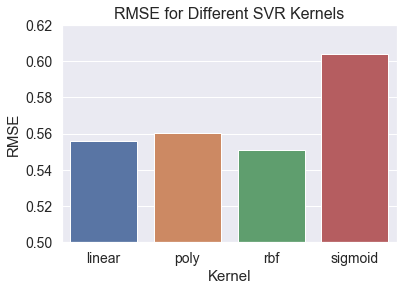

In [83]:
ax = sns.barplot(x=list(svr_kernel.keys()), y=list(svr_kernel.values()))
# plt.setp(ax.get_xticklabels(), rotation=90);
plt.ylim(.5,.62);
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel('Kernel', fontsize=15);
ax.set_ylabel('RMSE', fontsize=15);
ax.set_title("RMSE for Different SVR Kernels", fontsize=16);

Best kernel is rbf

In [84]:
svr_rbf_c_results = {}

In [85]:
for c in range(2, 41, 2):
    c = c / 10
    svr = SVR(kernel="rbf",C=c)
    svr.fit(X_train, y_train_int)
    preds = roundPred(svr.predict(X_test))

    RMSE = rmse(test_df["meanGrade"], (np.array(preds) / 10))
    svr_rbf_c_results[c] = RMSE
    print(c, RMSE)

0.2 0.5641146890388665
0.4 0.5585590553128766
0.6 0.5552025353977704
0.8 0.5527034164508379
1.0 0.5511589128085033
1.2 0.5499231409335947
1.4 0.5489826737003183
1.6 0.5481028952623372
1.8 0.5475921965520323
2.0 0.5471088655739208
2.2 0.5465776872973718
2.4 0.5463603878565576
2.6 0.546268941179673
2.8 0.5461571564306953
3.0 0.5459578624749176
3.2 0.5458815702277782
3.4 0.5460253996669373
3.6 0.5459404089609231
3.8 0.5461546586089857
4.0 0.5462676546877747


In [86]:
sorted(svr_rbf_c_results.items(), key=lambda x: x[1])[0]

(3.2, 0.5458815702277782)

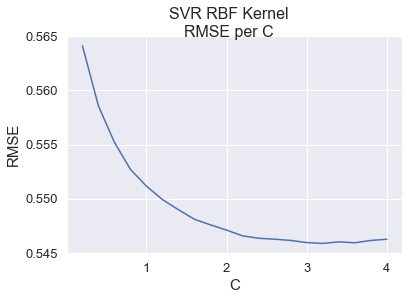

In [87]:
svr_rbf_c_results_df = (
    pd.DataFrame(svr_rbf_c_results.items(), columns=["C", "RMSE"])
    .sort_values("C")
    .reset_index(drop=True)
)
ax = sns.lineplot(x="C", y="RMSE", data=svr_rbf_c_results_df, color="b")
plt.suptitle("SVR RBF Kernel\nRMSE per C", fontsize=16)
ax.set_xlabel("C", fontsize=15)
ax.set_ylabel("RMSE", fontsize=15)
ax.xaxis.set_tick_params(labelsize=13)
ax.yaxis.set_tick_params(labelsize=13)

In [88]:
svr_rbf_epsilon_results = {}

In [89]:
for e in range(1, 11, 1):
    epsilon = e / 10
    svr = SVR(kernel="rbf",C=3.2, epsilon=e)
    svr.fit(X_train, y_train_int)
    preds = roundPred(svr.predict(X_test))

    RMSE = rmse(test_df["meanGrade"], (np.array(preds) / 10))
    svr_rbf_epsilon_results[epsilon] = RMSE
    print(epsilon, RMSE)

0.1 0.5454717570912433
0.2 0.5460800214533659
0.3 0.5460931934573725
0.4 0.5463488490908097
0.5 0.5483195418430101
0.6 0.5504506778442083
0.7 0.5540773738880254
0.8 0.5606534824720345
0.9 0.5708684810479461
1.0 0.585588816569932


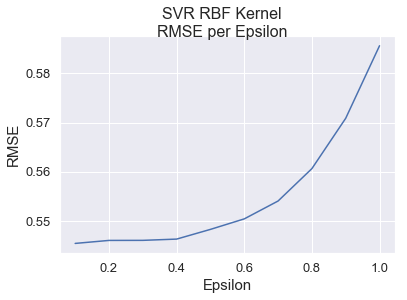

In [90]:
svr_rbf_epsilon_results_df = (
    pd.DataFrame(svr_rbf_epsilon_results.items(), columns=["Epsilon", "RMSE"])
    .sort_values("Epsilon")
    .reset_index(drop=True)
)
ax = sns.lineplot(x="Epsilon", y="RMSE", data=svr_rbf_epsilon_results_df, color="b")
plt.suptitle("SVR RBF Kernel\nRMSE per Epsilon", fontsize=16)
ax.set_xlabel("Epsilon", fontsize=15)
ax.set_ylabel("RMSE", fontsize=15)
ax.xaxis.set_tick_params(labelsize=13)
ax.yaxis.set_tick_params(labelsize=13)

## Best Model

| Parameter | Value   |
|-----------|---------|
| Model     | SVR     |
| Kernel    | rbf     |
| C         | 3.2     |
| Epsilon   | 0.1     |
| RMSE      | 0.54588 |

In [91]:
best_model = SVR(kernel="rbf", C=3.2, epsilon=0.1)
best_model.fit(X_train, y_train_int)
best_predictions = roundPred(best_model.predict(X_test))

best_RMSE = rmse(test_df["meanGrade"], (np.array(best_predictions) / 10))
print(f"Best Model RMSE: {best_RMSE:.5f}")

Best Model RMSE: 0.54588


In [92]:
model_results["Best Model"] = best_RMSE

## Results to a CSV

In [93]:
def preds_to_csv(df, predictions, file_name="results/task-1/task-1-output.csv"):
    final_df = pd.DataFrame(df["id"])
    if max(predictions) > 3:
        predictions = np.array(predictions) / 10
    final_df["pred"] = predictions
    final_df.to_csv("results/task-1/task-1-output.csv", index=False)
    return f"Final Predictions saved to: {file_name}"

In [94]:
# preds_to_csv(test_df, best_predictions)

## Data Visualization

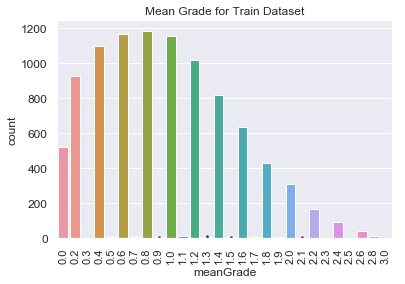

In [96]:
data = (
    y_train
    .value_counts()
    .reset_index()
    .sort_values("index")
    .rename(columns={"meanGrade": "count", "index": "meanGrade"})
).round(1)

ax = sns.barplot(x="meanGrade", y="count", data=data)
plt.setp(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_title("Mean Grade for Train Dataset");

In [97]:
baseline_preds = np.array([meanGrade] * len(y_test))

In [98]:
y_preds_df = pd.Series(baseline_preds).value_counts().reset_index().rename(columns={"index":"meanGrade",0:"Count"})

In [99]:
y_test_df = y_test.value_counts().reset_index().rename(columns={"index":"meanGrade","meanGrade":"Count"})

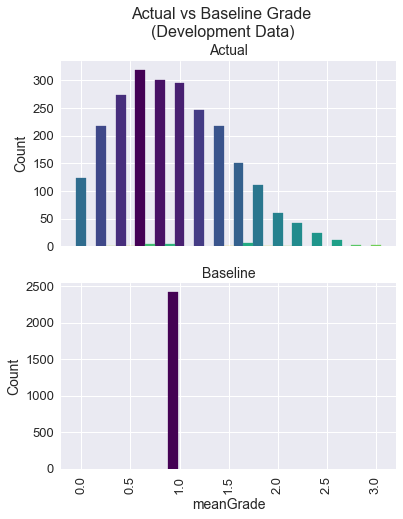

In [100]:
plt.style.use(['seaborn'])
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6,7.5), sharex=True)
bar_1 = ax1.bar(y_test_df["meanGrade"], y_test_df["Count"], width=.1)
bar_2 = ax2.bar(y_preds_df["meanGrade"], y_preds_df["Count"], width=.1)

for i, b in enumerate(bar_1):
    b.set_color(plt.cm.viridis(1. * i / (len(y_test_df) - 1)))

for i, b in enumerate(bar_2):
    b.set_color(plt.cm.viridis(1. * i / (len(y_test_df) - 1)))

ax1.set_xlabel("")
ax2.set_xlabel("meanGrade", fontsize=14)
ax1.set_ylabel("Count", fontsize=14)
ax2.set_ylabel("Count", fontsize=14)
plt.setp(ax1.get_xticklabels(), rotation=90)
plt.setp(ax2.get_xticklabels(), rotation=90)
ax1.set_title("Actual", fontsize=14)
ax2.set_title("Baseline", fontsize=14)
ax2.xaxis.set_tick_params(labelsize=13)
ax1.yaxis.set_tick_params(labelsize=13)
ax2.yaxis.set_tick_params(labelsize=13)
fig.subplots_adjust(hspace=.2)
fig.suptitle("Actual vs Baseline Grade \n(Development Data)", fontsize=16);

In [101]:
model_results_df = pd.DataFrame(model_results.items(), columns=["Model","RMSE"]).sort_values("RMSE")

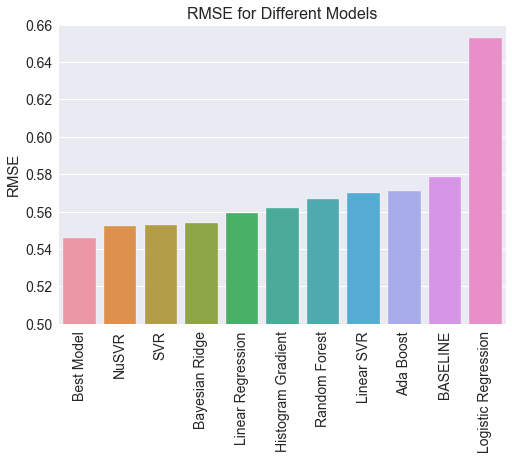

In [102]:
ax = sns.barplot(x="Model", y="RMSE", data=model_results_df)
plt.setp(ax.get_xticklabels(), rotation=90);
plt.ylim(.5,.66);
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel('');
ax.set_ylabel('RMSE', fontsize=15);
ax.set_title("RMSE for Different Models", fontsize=16);

In [104]:
y_best_preds_df = pd.Series(roundPred(np.array(best_predictions) / 10)).value_counts().reset_index().rename(columns={"index":"meanGrade",0:"Count"})

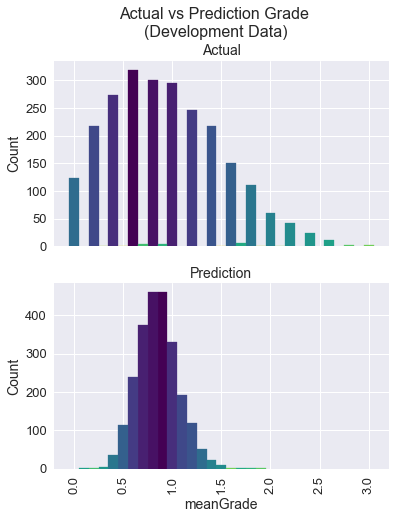

In [105]:
plt.style.use(['seaborn'])
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6,7.5), sharex=True)

bar_1 = ax1.bar(y_test_df["meanGrade"], y_test_df["Count"], width=.1)
# sns.barplot(x="meanGrade",y="Count", data=y_preds_df, ax=ax2)
bar_2 = ax2.bar(y_best_preds_df["meanGrade"], y_best_preds_df["Count"], width=.1)

for i, b in enumerate(bar_1):
    b.set_color(plt.cm.viridis(1. * i / (len(y_test_df) - 1)))

for i, b in enumerate(bar_2):
    b.set_color(plt.cm.viridis(1. * i / (len(y_test_df) - 1)))

ax1.set_xlabel("")
ax2.set_xlabel("meanGrade", fontsize=14)
ax1.set_ylabel("Count", fontsize=14)
ax2.set_ylabel("Count", fontsize=14)
plt.setp(ax1.get_xticklabels(), rotation=90)
plt.setp(ax2.get_xticklabels(), rotation=90)
ax1.set_title("Actual", fontsize=14)
ax2.set_title("Prediction", fontsize=14)
ax2.xaxis.set_tick_params(labelsize=13)
ax1.yaxis.set_tick_params(labelsize=13)
ax2.yaxis.set_tick_params(labelsize=13)
fig.subplots_adjust(hspace=.2)
fig.suptitle("Actual vs Prediction Grade \n(Development Data)", fontsize=16);

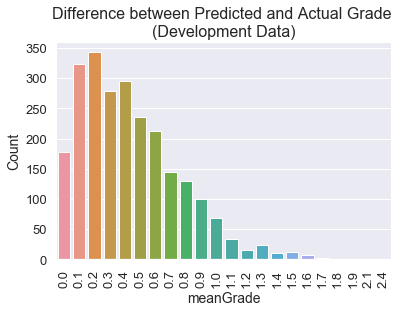

In [163]:
diffs = []
for x in range(len(best_predictions)):
    pred = best_predictions[x] / 10
    actual = y_test.iloc[x]
    diffs.append(abs(round(pred-actual,1)))
    
ax = sns.countplot(diffs)
plt.setp(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_title("Difference between Predicted and Actual Grade \n(Development Data)", fontsize=16);
ax.set_xlabel("meanGrade",fontsize=14)
ax.set_ylabel("Count",fontsize=14)
ax.yaxis.set_tick_params(labelsize=13)
ax.xaxis.set_tick_params(labelsize=13)

# Appendix

## Previous Text Representation

### Lemmatize

https://scikit-learn.org/stable/modules/feature_extraction.html#customizing-the-vectorizer-classes

In [47]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()

    def __call__(self, doc):
        return [
            self.wnl.lemmatize(t)
            for t in word_tokenize(doc)
            if len(t) >= 2 and t.isalpha() and t not in stop_words
        ]

### Bag of Words

In [7]:
unigram = (1, 1)
bigram = (1, 2)
trigram = (1, 3)
n_gram = bigram

In [8]:
bow_train = CountVectorizer(
    strip_accents="ascii",
    lowercase=True,
    stop_words=stop_words,
    ngram_range=n_gram,
    min_df=2,
)
X_train = bow_train.fit_transform(train_df["original"])

train_vocab = bow_train.get_feature_names()


bow_test = CountVectorizer(
    strip_accents="ascii",
    lowercase=True,
    stop_words=stop_words,
    ngram_range=n_gram,
    min_df=2,
    vocabulary=train_vocab,
)

X_test = bow_test.fit_transform(test_df["original"])


bow_train_edit = TfidfVectorizer(
    tokenizer=LemmaTokenizer(),
    strip_accents="ascii",
    lowercase=True,
    stop_words=stop_words,
    ngram_range=n_gram,
    min_df=2,
)
X_train_edit = bow_train_edit.fit_transform(train_df["new"])

X_train = hstack((X_train, X_train_edit))


bow_test_edit = TfidfVectorizer(
    tokenizer=LemmaTokenizer(),
    strip_accents="ascii",
    lowercase=True,
    stop_words=stop_words,
    ngram_range=n_gram,
    vocabulary=bow_train_edit.get_feature_names(),
    min_df=2,
)
X_test_edit = bow_test_edit.fit_transform(test_df["new"])

X_test = hstack((X_test, X_test_edit))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'might', 'must', 'need', 'sha', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'might', 'must', 'need', 'sha', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


### TF-IDF

In [66]:
tf_idf_train = TfidfVectorizer(
    tokenizer=LemmaTokenizer(),
    strip_accents="ascii",
    lowercase=True,
    stop_words=stop_words,
    ngram_range=n_gram,
    min_df=5,
)
X_train = tf_idf_train.fit_transform(train_df["original"])

train_vocab = tf_idf_train.get_feature_names()


tf_idf_test = TfidfVectorizer(
    tokenizer=LemmaTokenizer(),
    strip_accents="ascii",
    lowercase=True,
    stop_words=stop_words,
    ngram_range=n_gram,
    vocabulary=train_vocab,
    min_df=5,
)

X_test = tf_idf_test.fit_transform(test_df["original"])

Add Edit to the Train Features

In [10]:
tf_idf_train_edit = TfidfVectorizer(
    tokenizer=LemmaTokenizer(), strip_accents="ascii", lowercase=True, stop_words=stop_words, ngram_range=n_gram, min_df=5
)
X_train_edit = tf_idf_train_edit.fit_transform(train_df["edit"])

In [11]:
X_train = hstack((X_train, X_train_edit))

In [12]:
tf_idf_test_edit = TfidfVectorizer(
    tokenizer=LemmaTokenizer(), strip_accents="ascii", lowercase=True, stop_words=stop_words, ngram_range=n_gram, vocabulary=tf_idf_train_edit.get_feature_names(), min_df=5
)
X_test_edit = tf_idf_test_edit.fit_transform(test_df["edit"])

In [13]:
X_test = hstack((X_test, X_test_edit))

## Old Utility Functions

In [14]:
def addToSparse(spm, new_col):
    spm = hstack((spm,np.array(new_col)[:,None]))
    return spm

In [15]:
def maxGradeCalc(series):
    max_vals = []
    for val in series:
        max_vals.append(max([int(x) for x in list(str(val))]))
    return max_vals

In [16]:
def minGradeCalc(series):
    min_vals = []
    for val in series:
        min_vals.append(min([int(x) for x in list(str(val))]))
    return min_vals

In [17]:
def medianGradeCalc(series):
    med_vals = []
    for val in series:
        med_vals.append(np.median([int(x) for x in list(str(val))]))
    return med_vals

In [18]:
def addCols(X, df):
    X = addToSparse(X, maxGradeCalc(df["grades"]))
    X = addToSparse(X, minGradeCalc(df["grades"]))
    X = addToSparse(X, medianGradeCalc(df["grades"]))
    return X

In [307]:
def dfFromSparse(spm):
    return pd.DataFrame.sparse.from_spmatrix(spm)

In [20]:
X_train = addCols(X_train, train_df)
X_test = addCols(X_test, test_df)

## A bunch of other classifiers

In [359]:
from sklearn.neural_network import MLPRegressor, BernoulliRBM
from sklearn.linear_model import HuberRegressor, RANSACRegressor, TheilSenRegressor
from sklearn.linear_model import (
    ElasticNet,
    ElasticNetCV,
    Lars,
    LarsCV,
    LassoCV,
    LassoLars,
    LassoLarsIC,
    OrthogonalMatchingPursuit,
    OrthogonalMatchingPursuitCV,
    Perceptron,
    Ridge,
    RidgeCV,
    SGDRegressor,
)

In [360]:
mlp = SGDRegressor()
mlp.fit(X_train, y_train)
a = rmse(test_df["meanGrade"], np.array(roundPred(mlp.predict(X_test))))
print(a)

0.563092506371473


In [328]:
for e in range(10, 20, 1):
    e = e / 10
    mlp = HuberRegressor(epsilon=e)
    mlp.fit(X_train, y_train)
    a = rmse(test_df["meanGrade"], np.array(roundPred(mlp.predict(X_test))))
    print(a)

0.5704084971829719
0.568753705201692
0.5658973126808254
0.5640570865242328
0.5616738110584626
0.559948913987089
0.5594429698763105
0.5599046159834608
0.5590401033224521
0.5592434208850602
